In [1]:
import nilearn
import nilearn.datasets
import nilearn.plotting
import numpy as np
from nilearn._utils.helpers import check_matplotlib
from nilearn.maskers import NiftiMasker
from nilearn.mass_univariate import permuted_ols

check_matplotlib()

/home/local/KHQ/lee.newberg/venv/abcd311/lib/python3.11/site-packages/nilearn/datasets/data/mni_icbm152_t1_tal_nlin_sym_09a_converted.nii.gz


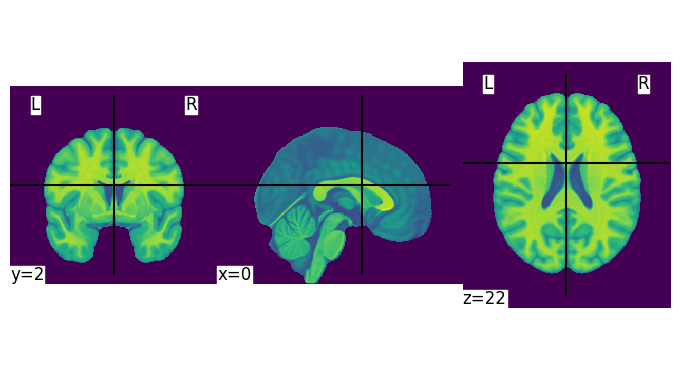

In [2]:
print(nilearn.datasets.MNI152_FILE_PATH)
nilearn.plotting.plot_img(nilearn.datasets.MNI152_FILE_PATH)

In [3]:
n_samples = 94
localizer_dataset = nilearn.datasets.fetch_localizer_contrasts(
    ["left button press (auditory cue)"], n_subjects=n_samples, legacy_format=False
)

# print basic information on the dataset
print("First contrast nifti image (3D) is located " f"at: {localizer_dataset.cmaps[0]}")

tested_var = localizer_dataset.ext_vars["pseudo"]

# Quality check / Remove subjects with bad tested variate
mask_quality_check = np.where(np.logical_not(np.isnan(tested_var)))[0]
n_samples = mask_quality_check.size
contrast_map_filenames = [localizer_dataset.cmaps[i] for i in mask_quality_check]
tested_var = tested_var[mask_quality_check].to_numpy().reshape((-1, 1))
print(f"Actual number of subjects after quality check: {int(n_samples)}")

[get_dataset_dir] Dataset found in /home/local/KHQ/lee.newberg/nilearn_data/brainomics_localizer
First contrast nifti image (3D) is located at: /home/local/KHQ/lee.newberg/nilearn_data/brainomics_localizer/brainomics_data/S01/cmaps_LeftAuditoryClick.nii.gz
Actual number of subjects after quality check: 89


In [4]:
nifti_masker = nilearn.maskers.NiftiMasker(smoothing_fwhm=5, memory="nilearn_cache", memory_level=1)
fmri_masked = nifti_masker.fit_transform(contrast_map_filenames)

In [5]:
from sklearn.feature_selection import f_regression

_, pvals_anova = f_regression(fmri_masked, tested_var, center=True)
pvals_anova *= fmri_masked.shape[1]
pvals_anova[np.isnan(pvals_anova)] = 1
pvals_anova[pvals_anova > 1] = 1
neg_log_pvals_anova = -np.log10(pvals_anova)
neg_log_pvals_anova_unmasked = nifti_masker.inverse_transform(neg_log_pvals_anova)

/home/local/KHQ/lee.newberg/venv/abcd311/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [6]:
ols_outputs = nilearn.mass_univariate.permuted_ols(
    tested_var,  # this is equivalent to the design matrix, in array form
    fmri_masked,
    model_intercept=True,
    masker=nifti_masker,
    tfce=True,
    n_perm=200,  # 200 for the sake of time. Ideally, this should be 10000.
    verbose=1,  # display progress bar
    n_jobs=2,  # can be changed to use more CPUs
    output_type="dict",
)
neg_log_pvals_permuted_ols_unmasked = nifti_masker.inverse_transform(
    ols_outputs["logp_max_t"][0, :]  # select first regressor
)
neg_log_pvals_tfce_unmasked = nifti_masker.inverse_transform(
    ols_outputs["logp_max_tfce"][0, :]  # select first regressor
)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.2min finished


Text(0.5, 1.3, 'Group left button press ($-\\log_{10}$ p-values)')

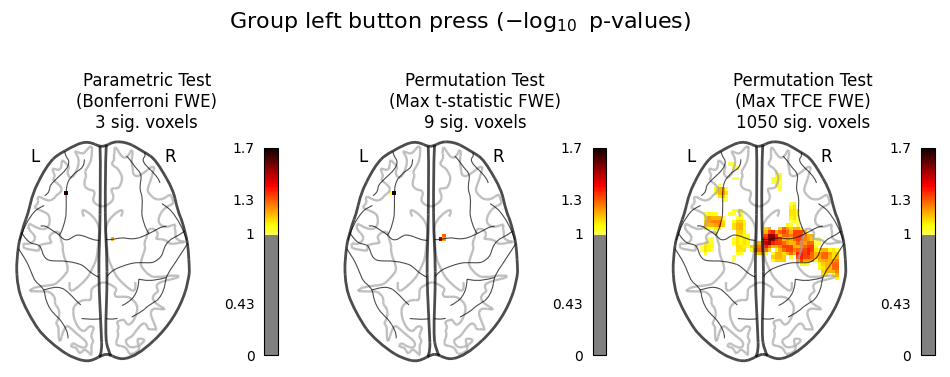

In [7]:
import matplotlib.pyplot as plt

from nilearn import plotting
from nilearn.image import get_data

# Various plotting parameters
z_slice = 12  # plotted slice
threshold = -np.log10(0.1)  # 10% corrected

vmax = max(
    np.amax(ols_outputs["logp_max_t"]),
    np.amax(neg_log_pvals_anova),
    np.amax(ols_outputs["logp_max_tfce"]),
)

images_to_plot = {
    "Parametric Test\n(Bonferroni FWE)": neg_log_pvals_anova_unmasked,
    "Permutation Test\n(Max t-statistic FWE)": (neg_log_pvals_permuted_ols_unmasked),
    "Permutation Test\n(Max TFCE FWE)": neg_log_pvals_tfce_unmasked,
}

fig, axes = plt.subplots(figsize=(12, 3), ncols=3)
for i_col, (title, img) in enumerate(images_to_plot.items()):
    ax = axes[i_col]
    n_detections = (get_data(img) > threshold).sum()
    new_title = f"{title}\n{n_detections} sig. voxels"

    plotting.plot_glass_brain(
        img,
        colorbar=True,
        vmax=vmax,
        display_mode="z",
        plot_abs=False,
        cut_coords=[12],
        threshold=threshold,
        figure=fig,
        axes=ax,
    )
    ax.set_title(new_title)

fig.suptitle("Group left button press ($-\\log_{10}$ p-values)", y=1.3, fontsize=16)